# Open-Science-prize quantum challenge 2021/22 by Quantum Polo Gang

# Abstract

We decide to split the XXX Hamiltonian into two pieces $H=H_1+H_2$ (instead of 6):
$$    H_1=I^{(0)} \otimes \sigma_x^{(1)} \otimes \sigma_x^{(2)}  + I^{(0)}  \otimes  \sigma_y^{(1)} \otimes \sigma_y^{(2)} + I^{(0)}  \otimes \sigma_z^{(0)} \otimes \sigma_z^{(1)}$$
$$ H_2=\sigma_x^{(0)}\otimes \sigma_x^{(1)} \otimes I^{(2)}  +  \sigma_y^{(0)} \otimes \sigma_y^{(1)} \otimes I^{(2)} + \sigma_z^{(0)} \otimes \sigma_z^{(1)} \otimes I^{(2)}$$

so using Trotter's formula (for a fixed number of steps $N$):
$$ e^{-iHt}=e^{-i(H_1 + H_2)t} \simeq \left(e^{-iH_1\frac{t}{N}}e^{-iH_2\frac{t}{N}}\right)^N \equiv (T_{step})^N \equiv T(t)$$

Our main goal is to find the operator $U_{best}$ for which the number of gates is minimum and for which holds (at all times):

$$U_{best}(t) \ket{110} = T(t) \ket{110}$$

This can be intended in two ways:

* $U_{best} = T$ (equality between operators)
* $U_{best} \neq T$, but the two different operators applied to the same vector yield the same result

We followed both approaches, the former will be called *Hilbert Space Decomposition* (HSD) while for the latter we chose the name of *Single State Decomposition* (SSD).

For HSD the best circuit we found is composed of 11 cnots (14 for the Jakarta geometry) while for the SSD approach we reached an even better 4 cnots solution.

Furthermore, referring to qiskit's measurement error mitigation strategy (*https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html*), we tried to model also the noise introduced by the circuit instead of narrowing ourselves down to measurement error only.

# 1) Decompositions

We suggest two possible decomposition methods. Both are attempts to reconduce the trotterized evolution to two-qubit gates, since those are decomposed more efficiently. 

## 1.1) Single State Decomposition

We start from observing that the hamiltonian preserves the magnetization:
$$m = \sum_i \sigma_z^{(i)}$$
We want to mimic the 3-qubit gate using two 2-qubit gates in succession, thus the subgates must preserve the magnetization too.
$$U_{best} = \left( \mathbb{I}^{(0)} \otimes M^{(1,2)} \right) \cdot \left( M^{(0,1)} \otimes \mathbb{I}^{(2)}  \right)  $$
We search thus the most general form of a 2-qubit magnetization-preserving gate.
Following *reference*, we know that such an operator has the parametric form:

$$ M(\omega,\theta, \phi) = \left[\begin{matrix}e^{ -i \left( \phi + \theta\right)} & 0 & 0 & 0\\ 0 & e^{-  i \left(\phi + \theta\right)} \cos{\left(\omega \right)} & - e^{-  i \left( \phi - \theta\right)} \sin{\left(\omega \right)} & 0\\ 0 & e^{ i \left( \phi - \theta\right)} \sin{\left(\omega \right)} & e^{ i \left( \phi + \theta\right)} \cos{\left(\omega \right)} & 0\\ 0 & 0 & 0 & e^{ i \left( \phi + \theta\right)}\end{matrix}\right] $$

and can be decomposed with 2 c-nots.

Fixed the initial state to $\ket{110}$, we have that $M^{(1,2)}M^{(0,1)}\ket{110}$ spans the whole magnetization eigenspace. 
$$U_{best} = \left(  \mathbb{I} \otimes M(\omega_2,\theta_2, \phi_2)\right)     \cdot     \left( M(\omega_1,\theta_1, \phi_1) \otimes \mathbb{I} \right)   $$

So taking: $$T\ket{110} = \alpha \ket{011} + \beta \ket{101} + \gamma \ket{110}$$

where $T$ is computed numerically and: 

$$\begin{align*}

U_{best}\ket{110} =\; &e^{i(\theta_1 - \phi_1 + \theta_2 - \phi_2)}\sin(\omega_1)\sin(\omega_2) \ket{011} +\\
& e^{i(\theta_1-\phi_1-\theta_2-\phi_2-\pi)}\sin(\omega_1)\cos(\omega_2) \ket{101} + \\
&e^{i(\theta_1+\phi_1+\theta_2+\phi_2)}\cos(\omega_2) \ket{110}

\end{align*}$$

Matching the amplitudes and solving the system for $\{\omega, \theta, \phi \}_{1,2}$ we get the parameters for the gates $M^{(0,1)}$ and $M^{(1,2)}$.


## Circuits:

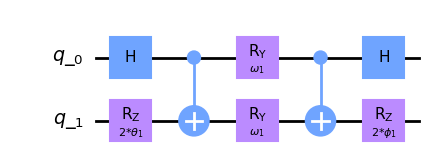

In [81]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

def get_M(theta, phi, omega, name="M"): # defining the M matrix

    qr=QuantumRegister(2, name="q_")
    M_qc=QuantumCircuit(qr, name=name)

    M_qc.rz(2*theta,qr[1])
    M_qc.h(qr[0])
    M_qc.cx(qr[0],qr[1])
    M_qc.ry(omega,qr)
    M_qc.cx(qr[0],qr[1])
    M_qc.h(qr[0])
    M_qc.rz(2*phi,qr[1])

    return M_qc

theta_1, phi_1, omega_1  = Parameter(r'$\theta_1$'), Parameter(r'$\phi_1$'), Parameter(r'$\omega_1$')

M1_qc = get_M(theta_1, phi_1, omega_1, name=r"$M_1$")

M1_qc.draw(output="mpl", style={"figwidth":6, "fontsize":11})

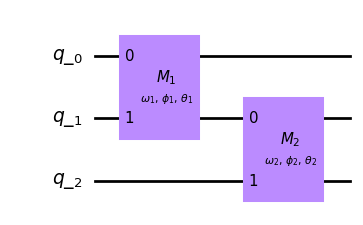

In [82]:
theta_2, phi_2, omega_2  = Parameter(r'$\theta_2$'), Parameter(r'$\phi_2$'), Parameter(r'$\omega_2$')
M2_qc = get_M(theta_2, phi_2, omega_2, name=r"$M_2$")

#building the circuit of U_best
U_best_qr = QuantumRegister(3, name = "q_")
U_best_qc = QuantumCircuit(U_best_qr, name = r"$U_{best}$")

U_best_qc.append(M1_qc, [U_best_qr[0],U_best_qr[1]])
U_best_qc.append(M2_qc, [U_best_qr[1],U_best_qr[2]])

U_best_qc.draw(output = "mpl", style={"figwidth":5, "fontsize":11})

## 1.2) Hilbert Space Decomposition
This decomposition is based on the observation that the trotter step matrix can be reduced to  2-block matrix by a permutation of the basis elements:

$$B T_{step}^N B^{\dagger} = \mathbb{I}^{(2)} \otimes D^{(1,0)} $$

where $B$ is the matrix associated with the permutation $(0, 3, 4)\cdot(1, 2)$, that in matrix form is

$$B = \left[
\begin{matrix}
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\end{matrix}
\right]$$

Therefore

$$ T_{B}(t) = B T(t) B^{\dagger}$$

is a two qubit gate. Aplying the associated change of basis before and after this gate it is possible to reproduce the time evolution. 

Since the initial state is just a permutation of the prepared state, we can prepare it already in the permutated one.
$$ \ket{\psi}_{prepared} = B^{\dagger} \ket{\psi}_{init} $$

Then we use `qiskit.transpile()` function to decompose $D$ (up to 3 c-nots), and we find the circuit for B using the permutation gates: x, c-not and toffoli.

We also note that $B\ket{110} = \ket{110}$


## Circuits:

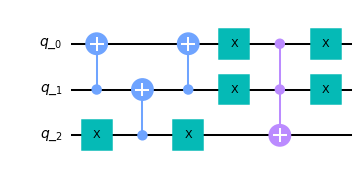

In [83]:
import numpy as np
# Build the permutation operator
B_qr=QuantumRegister(3, name="q_")
B_qc=QuantumCircuit(B_qr, name="B")
B_qc.x(B_qr[2])
B_qc.cx(B_qr[1],B_qr[0])
B_qc.cx(B_qr[2],B_qr[1])
B_qc.cx(B_qr[1],B_qr[0])
B_qc.x([B_qr[0],B_qr[1],B_qr[2]])
B_qc.toffoli(B_qr[0],B_qr[1],B_qr[2])
B_qc.x([B_qr[0],B_qr[1]])

# Matrix associated to this circuit
B = np.array(
   [[0,0,0,0,1,0,0,0],
    [0,0,1,0,0,0,0,0],
    [0,1,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0],
    [0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,1]]
)

B_qc.draw(output="mpl", style={"figwidth":5, "fontsize":11})

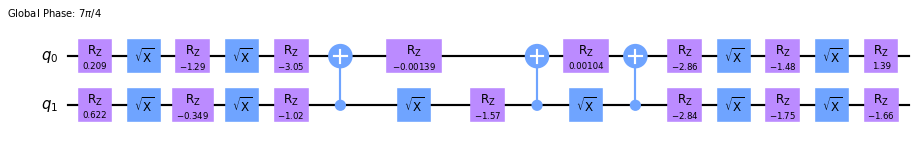

In [84]:
# The matrix D is a block of B' T B

# To avoid code redundancy, we defined the trotter operation 
# in the external script utilities.py
N_STEPS = 99
TIME = np.pi

from lib import utilities
T = utilities.trotterized_matrix(TIME, N_STEPS)
T_b = np.linalg.multi_dot([ B, T, B.transpose() ])

D = T_b[0:4, 0:4]

from qiskit import transpile
# Transpile the D operator and build the evolution circuit
D_qc = QuantumCircuit(2, name="D")
D_qc.unitary(D,[0,1])    
D_qc = transpile(D_qc, basis_gates=['cx','x','sx','rz']) # Jackarta basis gates

D_qc.draw(output="mpl", style={"figwidth":13, "fontsize":11})

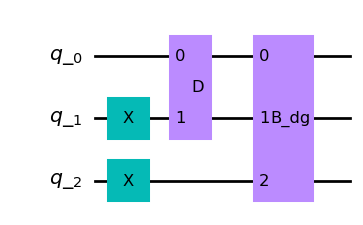

In [85]:
qr_evo = QuantumRegister(3, name="q_")
qc_evo = QuantumCircuit(qr_evo, name="D")

# the permutation of 110 is 110 itself, so we prepare it.
initial_state = "110"

for qubit in range(3):
    if initial_state[::-1][qubit] == "1":
        qc_evo.x(qr_evo[qubit])

qc_evo.append(D_qc, [qr_evo[0], qr_evo[1]])
qc_evo.append(B_qc.inverse(), qr_evo)

qc_evo.draw(output="mpl", style={"figwidth":5, "fontsize":12})

# 2) Mitigation

The following haphazard processes affect the performance of the circuit:
* measurement noise
* gate noise
* state preparation noise 

we neglect the noise introduced by state mispreparation, so we assume the following model:

$$ \vec{p_{n}} = \|U_{noisy}\| \vec{p_{0}} = M N \|U\| \vec{p_{0}}  = M N \vec{p_{i}} $$

Where $\vec{p}$ are the probability vector noisy and ideal, $N$ (*Circuit Noise Matrix*) and $M$ (*Measurment Noise Matrix*) are the stochastic matrices that rapresent the noise of circuit and measure.
We use $ \|U\|$ to intend the probability matrix (or Unistochastic) of U $$\|U\|_{ij}=|U_{ij}|^{2}$$


So, characterizing the probability matrices  $M$  and $N$ we could mitigate the results.


## 2.1) *Circuit Itself Calibration* (CIC)

We can built the matrix $ \tilde{U} = MN\|U\| $, just preparing all the $2^n$ computational basis states and evolve them with the circuit $U_{noisy}$ itself.
$$ \tilde{U}_{ij} =  \bra{j} MN\|U\| \ket{i} $$

So, the *calibration matrix* is:
$$ C = \tilde{U} \| U \|^{-1}  = MN  \|U\| \|U\|^{-1} = MN  $$

We note that if $||U||$ is not invertible must be excluded from this treatment($t=\pi$ is not the case).
In particular if we change the parameters of the circuit we need to redefine the calibration matrix because N changes
## Circuits:

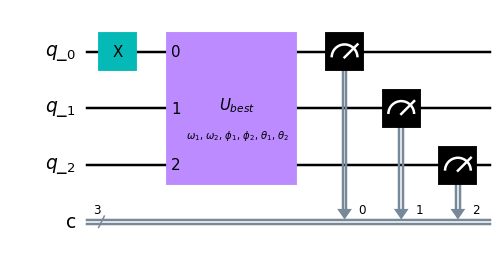

In [86]:
calib_circuits_CIC = []

state_labels = ['000', '001', '010', '011', '100', '101', '110', '111']  

for state in state_labels:
    cr_cal_itself = ClassicalRegister(3, name = "c")
    qr_cal_itself = QuantumRegister(3, name = "q_")
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{state}")
    # first we prepare the initial state.
    for qubit in [0,1,2]:
        if state[::-1][qubit] == "1":
            qc_cal_itself.x(qr_cal_itself[qubit])
    # then we append the circuit.
    qc_cal_itself.append(U_best_qc, qr_cal_itself)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_CIC.append(qc_cal_itself)
# example: for i = 1 we should preper the state |001> (gate x on first qubit).
calib_circuits_CIC[1].draw(output="mpl", style={"figwidth":7, "fontsize":12})


## 2.2) *Noisy Identity Calibration* (NIC)
In order to evaluate $ C = MN $, for all computational base states we use the following scheme:
* prepare the initial state in an eigenvector of $U$: $U\ket{\lambda} = \lambda \ket{\lambda}$.
* apply U
* apply an state preparation operator $O_{i, \lambda}$ such that: $O_{i, \lambda} \ket{\lambda} = \ket{i}$, where $\ket{i}$ is the i-th state of the computational basis.

So, running the circuits:
$$ C_{i,j} = \bra{j} MNO_{i, \lambda}U \ket{\lambda} = \bra{j} MN \ket{i} $$ 

For this specific case $\ket{000},\ket{111}$ are both eigenvector.

Unlike the previous method, this calibration does not require an inversion operation and, since the circuit acts as an identity, the calibration matrix has to be estimated only once.

## Circuits:

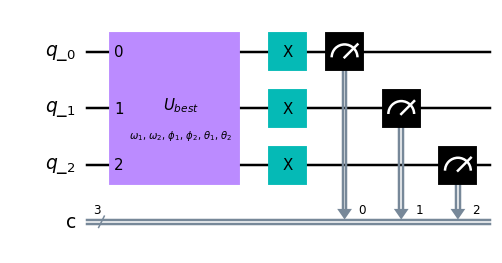

In [87]:
calib_circuits_NIC = []

for state in state_labels:
    cr_cal_id = ClassicalRegister(3, name = "c")
    qr_cal_id = QuantumRegister(3, name = "q_")
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{state}")
    # first we append the circuit.
    qc_cal_id.append(U_best_qc, qr_cal_id)
    # than we permute the state.
    for qubit in range(3):
        if state[::-1][qubit] == "1":
            qc_cal_id.x(qr_cal_id[qubit])

    qc_cal_id.measure(qr_cal_id, cr_cal_id)

    calib_circuits_NIC.append(qc_cal_id)
# example: for i = 7 we should get the final state |111> (gate x on all qubits).
calib_circuits_NIC[7].draw(output="mpl", style={"figwidth":7, "fontsize":12})


### *Fast Tomography Circuits Calibration*

Using NIC or CIC for each tomography base we should run $2^n$ circuit to calibrate it, so the total number of run would be $2^n \cdot 3^n$ calibration circuits, that is computationally high-expensive.

The *Fast Tomography Circuits Calibration* needs only $2^n$ calibration circuits.

The idea is to compute just once the calibration matrix in the computational basis and for every tomography base compute $$C_{H}=\|H\|C\|H^{\dagger}\|$$ where H is the new basis matrix.

\begin{comment}
Then to compute the calibration matrix in a basis $B$ at will one can just use the following: $$ \tilde{C} = M B M^{-1} C B^{-1} $$
We want to infer how the change of basis affects the noise.
We assume that the measurement noise acts on the circuit after the change of basis which in turn happens before the circuit noise:
$$ \ket{\psi_{ideal}} = BU\ket{\psi_0}$$
$$ \vec{p_{n}} = \|U_{noisy} \ket{\psi_0}\| = \|MHNU\ket{\psi_0}\| = MBNB^{-1}\vec{p_{i}}$$
Since the previous strategies can estimate jointly $C \equiv MN$ and not $N$ alone, we can do so
$$\tilde{C} = MBNB^{-1} = MBM^{-1}MNB^{-1} = MBM^{-1} \cdot C B^{-1} $$
And the new matrix $\tilde{C}$ is the noise matrix in the new basis. The remarkable fact is that once $C$ is computed by one of the methods previously stated, it is possible to obtain the noise in every basis, given that we know the change of base matrix $B$.
\end{comment}



# 3) results and conclusion

In [88]:
import numpy as np
from scipy.linalg import expm

# defining the evolution paramiters
N_Trotter_Steps = 99
evolution_time = np.pi

In [89]:
X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the two hamiltonian pizes: 
H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.
trotter_step_matrix_= expm(-evolution_time/N_Trotter_Steps*H1*1j).dot(expm(-evolution_time/N_Trotter_Steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, N_Trotter_Steps)

## 3.1) *Single State Decomposition* results

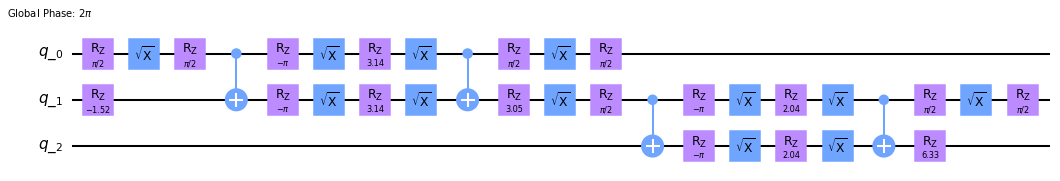

In [90]:
# getting the prameters for the gates M1 and M2, solving the equations described in 1.1).
theta_1, theta_2, phi_1, phi_2, omega_1, omega_2 = utilities.get_gates_parameters(trotterized, initial_state={"110": 1.0})
# build M1 and M2
M1_qc = get_M(theta_1, phi_1, omega_1)
M2_qc = get_M(theta_2, phi_2, omega_2)
# define the circuit of U
qr_U = QuantumRegister(3 ,name="q_")
qc_U = QuantumCircuit(qr_U, name="U")
# append the gates
qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])
# transpile and draw the circuit
from qiskit import transpile
qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl", style={"figwidth":15, "fontsize":12})

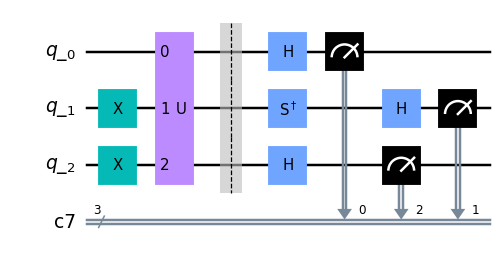

In [91]:
# building the tomography circuits
qr_evo = QuantumRegister(3, name="q_")
qc_evo = QuantumCircuit(qr_evo, name=r"$U_{best}$")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

from qiskit.ignis.verification.tomography import state_tomography_circuits

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl", style={"figwidth":7, "fontsize":12})

In [92]:
# building the calibration circuits
calib_circuits_NIC = utilities.get_calibration_circuits(qc_U, method="NIC")
calib_circuits_CIC = utilities.get_calibration_circuits(qc_U, method="CIC")

In [93]:
from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

shots = 20000

job_tomography=execute(qcs_tomo, backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])
job_NIC=execute(calib_circuits_NIC, backend = backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])
job_CIC=execute(calib_circuits_CIC, backend = backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])

ibmqfactory.load_account:WARNING:2022-04-12 16:50:06,163: Credentials are already in use. The existing account in the session will be replaced.


In [94]:
# building the matrices
from qiskit.utils.mitigation.fitters import CompleteMeasFitter

meas_fitter_NIC = CompleteMeasFitter(job_NIC.result(), state_labels=state_labels)
meas_fitter_CIC = CompleteMeasFitter(job_CIC.result(), state_labels=state_labels)

U_tilde_identity=meas_fitter_NIC.cal_matrix
U_tilde_itself=meas_fitter_CIC.cal_matrix

U_ideal = utilities.matrix_from_circuit(qc_U)

#defining the tomography basis circuits.
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)

C_matrices_NIC = []
C_matrices_CIC = []

U_ideal_abs = np.abs(U_ideal)**2
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)

C_itself = np.dot(U_tilde_itself, U_ideal_abs_inv)
C_identity = U_tilde_identity

# building the fast tomography circuits calibration.
for basis in tomography_basis:

    basis.remove_final_measurements()
    base_matrix_amplitudes = utilities.matrix_from_circuit(basis)
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    C_aus_itself = np.linalg.multi_dot([base_matrix, C_itself,  base_matrix_inverse])
    C_aus_identity = np.linalg.multi_dot([base_matrix, C_identity,  base_matrix_inverse])

    C_matrices_NIC.append(np.asarray(C_aus_identity))
    C_matrices_CIC.append(np.asarray(C_aus_itself))

import copy
meas_fitters_identity = []
meas_fitters_itself = []

for tomography_basis in range(3**3):
    meas_fitter_aus = copy.deepcopy(meas_fitter_NIC)
    meas_fitter_aus._tens_fitt.cal_matrices[0]=C_matrices_NIC[tomography_basis]
    meas_fitters_identity.append(meas_fitter_aus)

    meas_fitter_aus = copy.deepcopy(meas_fitter_CIC)
    meas_fitter_aus._tens_fitt.cal_matrices[0]=C_matrices_CIC[tomography_basis]
    meas_fitters_itself.append(meas_fitter_aus)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [95]:
from qiskit.opflow import One, Zero
target_state = (One^One^Zero).to_matrix()

raw_res = job_tomography.result()
NIC_res = copy.deepcopy(raw_res)
CIC_res = copy.deepcopy(raw_res)

for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_NIC = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    NIC_res.results[i].data.counts = new_counts_NIC

    new_counts_CIC = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    CIC_res.results[i].data.counts = new_counts_CIC

In [96]:
fid_raw = utilities.fidelity_count(raw_res, qcs_tomo, target_state)
fid_NIC = utilities.fidelity_count(NIC_res, qcs_tomo, target_state)
fid_CIC = utilities.fidelity_count(CIC_res, qcs_tomo, target_state)

print("evolution time = %.3f pi\nNumber of trotter steps = %d\n"%(TIME/np.pi, N_STEPS))
print(f"fidelity of raw results: {fid_raw} \nfidelity with NIC method: {fid_NIC}\nfidelity with CIC method: {fid_CIC}")

evolution time = 1.000 pi
Number of trotter steps = 99

fidelity of raw results: 0.8598355333527257 
fidelity with NIC method: 0.9964534391313009
fidelity with CIC method: 0.9996044098347737


## Conclusion


## 3.2) *Hilbert Space Decomposition* results